# Storage Metrics Data Analysis

This notebook analyzes the storage metrics data generated from October 1, 2024, to March 14, 2025. We'll explore patterns, trends, and insights in the data through various visualizations and analyses.

## 1. Data Loading and Initial Exploration

In [3]:
from google.colab import files
uploaded = files.upload()


Saving storage_metrics_history.csv to storage_metrics_history.csv


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plot styling
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 6]

# Load the data
file_path = 'storage_metrics_history.csv'
df = pd.read_csv(file_path)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create date and hour columns for time-based analysis
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month_name()

# Display basic information
print(f"Data spans from {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total records: {len(df)}")
print(f"Directories: {', '.join(df['directory'].unique())}")

# Show first few rows
df.head()

Data spans from 2024-10-01 00:00:00 to 2025-03-14 00:00:00
Total records: 15748
Directories: /data, /scratch, /projects, /user


,timestamp,directory,files_added,files_deleted,files_modified,size_added_gb,size_deleted_gb,size_modified_gb,total_files,current_space_gb,date,hour,day_of_week,month
0,2024-10-01 00:00:00,/data,0,0,0,0.000,0.000,0.000,17826,437.39,2024-10-01,0,Tuesday,October
1,2024-10-01 00:00:00,/scratch,0,0,0,0.000,0.000,0.000,19660,237.50,2024-10-01,0,Tuesday,October
2,2024-10-01 00:00:00,/projects,25,14,32,13.531,0.305,3.523,14208,379.80,2024-10-01,0,Tuesday,October
3,2024-10-01 00:00:00,/user,0,0,0,0.000,0.000,0.000,12360,300.48,2024-10-01,0,Tuesday,October
4,2024-10-01 01:00:00,/data,0,0,0,0.000,0.000,0.000,17826,437.39,2024-10-01,1,Tuesday,October


In [48]:
# Data summary
df.describe()

,timestamp,files_added,files_deleted,files_modified,size_added_gb,size_deleted_gb,size_modified_gb,total_files,current_space_gb,hour
count,15748,15748.000000,15748.000000,15748.000000,15748.000000,15748.000000,15748.000000,15748.000000,15748.000000,15748.000000
mean,2024-12-22 00:00:00,46.730886,39.880112,41.886081,21.094388,17.972801,2.658601,38681.146177,19863.695212,11.497079
min,2024-10-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.856000,12360.000000,237.500000,0.000000
25%,2024-11-11 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24348.250000,7153.737500,5.000000
50%,2024-12-22 00:00:00,26.000000,13.000000,24.000000,8.026500,3.578500,0.879000,38254.000000,15054.580000,11.000000
75%,2025-02-01 00:00:00,72.000000,39.000000,65.000000,27.995000,12.977000,3.196500,50890.750000,21868.075000,17.000000
max,2025-03-14 00:00:00,1114.000000,12768.000000,850.000000,1282.609000,12547.092000,60.186000,77898.000000,69633.920000,23.000000
std,NaN,66.977618,315.984986,55.593486,37.057486,212.163738,4.472076,15090.921503,17752.190552,6.923953


## 2. Storage Growth Analysis

<Figure size 1400x700 with 0 Axes>

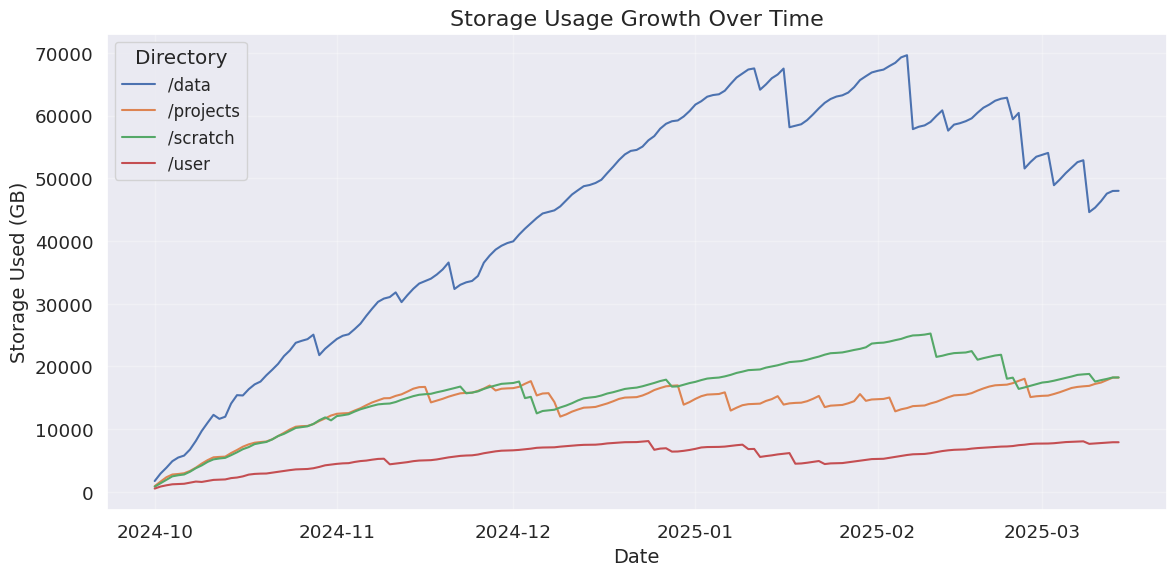

In [49]:
# Create a daily snapshot of space usage per directory
daily_space = df.groupby(['date', 'directory'])['current_space_gb'].last().unstack()

# Plot storage growth over time
plt.figure(figsize=(14, 7))
daily_space.plot()
plt.title('Storage Usage Growth Over Time', fontsize=16)
plt.ylabel('Storage Used (GB)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Directory', fontsize=12)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

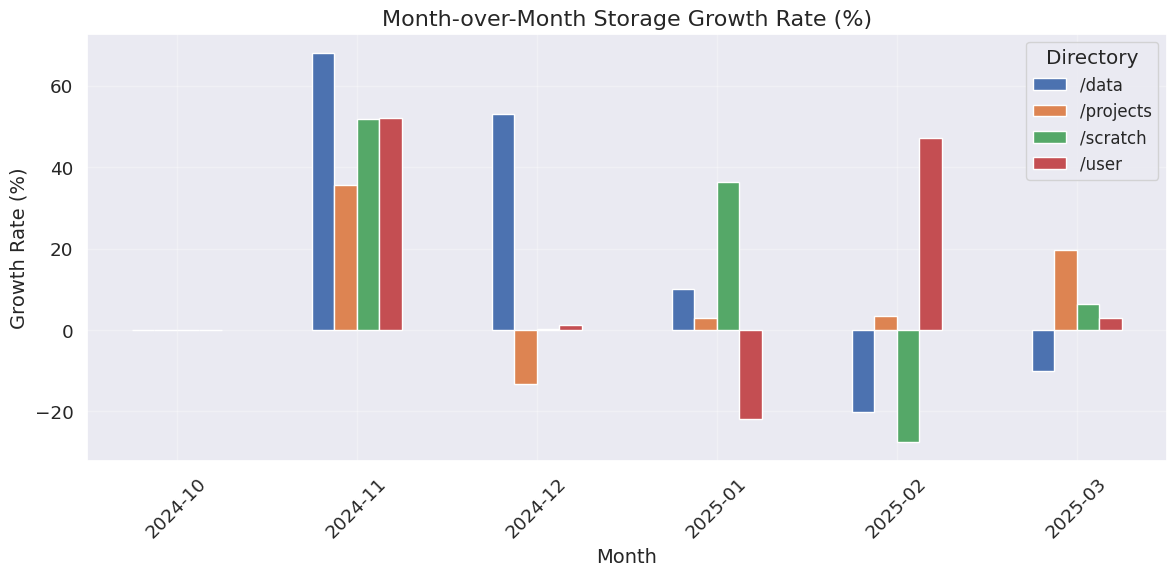

In [50]:
# Calculate month-over-month growth rates
# Group by month and directory to get the last value of each month
df['year_month'] = df['timestamp'].dt.to_period('M')
monthly_space = df.groupby(['year_month', 'directory'])['current_space_gb'].last().unstack()

# Calculate growth rates
monthly_growth = monthly_space.pct_change() * 100

# Display growth rates
plt.figure(figsize=(14, 7))
monthly_growth.plot(kind='bar')
plt.title('Month-over-Month Storage Growth Rate (%)', fontsize=16)
plt.ylabel('Growth Rate (%)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Directory', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. File Operation Analysis

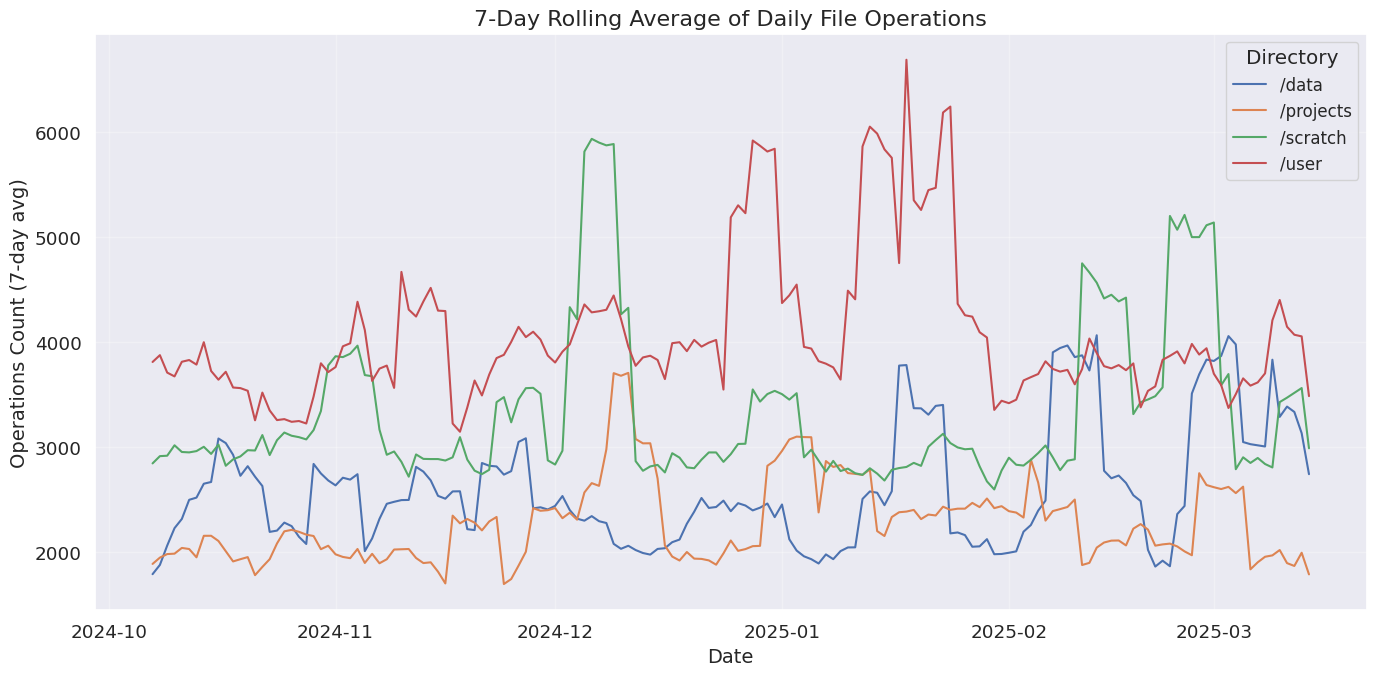

In [51]:
# Analyze file operations by directory
# Aggregate daily operations
daily_ops = df.groupby(['date', 'directory']).agg({
    'files_added': 'sum',
    'files_deleted': 'sum',
    'files_modified': 'sum'
}).reset_index()

# Calculate total operations
daily_ops['total_operations'] = daily_ops['files_added'] + daily_ops['files_deleted'] + daily_ops['files_modified']

# Calculate 7-day rolling average
rolling_ops = daily_ops.set_index('date').groupby('directory')[['total_operations']].rolling(7).mean().reset_index()

# Plot rolling average operations by directory
plt.figure(figsize=(14, 7))
for directory in daily_ops['directory'].unique():
    data = rolling_ops[rolling_ops['directory'] == directory]
    plt.plot(data['date'], data['total_operations'], label=directory)

plt.title('7-Day Rolling Average of Daily File Operations', fontsize=16)
plt.ylabel('Operations Count (7-day avg)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Directory', fontsize=12)
plt.tight_layout()
plt.show()

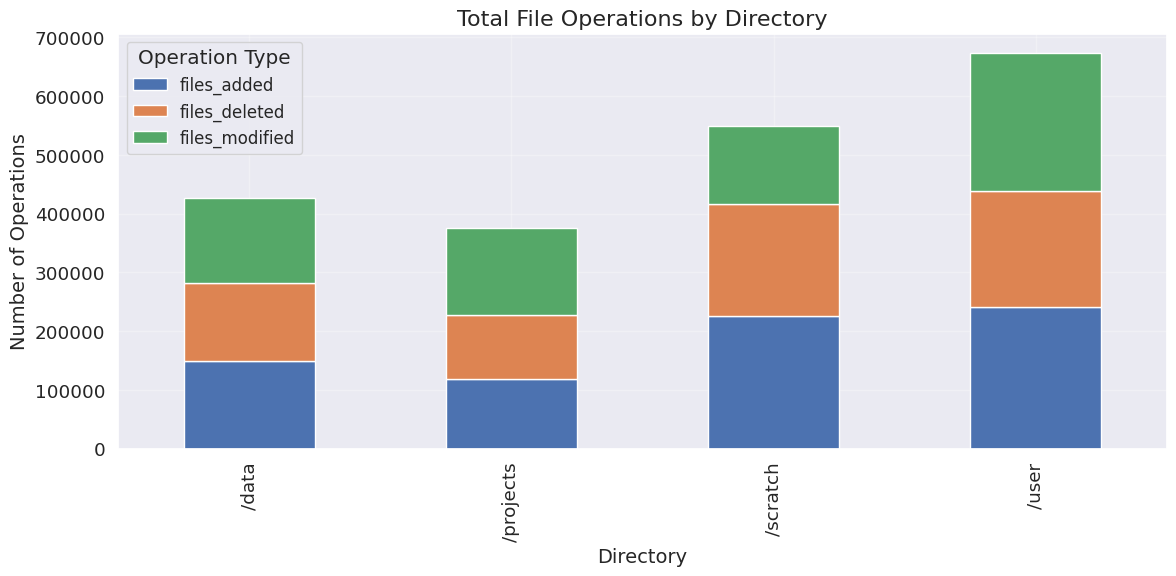

In [52]:
# Create a stacked bar chart of operation types by directory
ops_by_dir = df.groupby('directory').agg({
    'files_added': 'sum',
    'files_deleted': 'sum',
    'files_modified': 'sum'
})

# Plot
ops_by_dir.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total File Operations by Directory', fontsize=16)
plt.ylabel('Number of Operations', fontsize=14)
plt.xlabel('Directory', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Operation Type', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Temporal Patterns Analysis

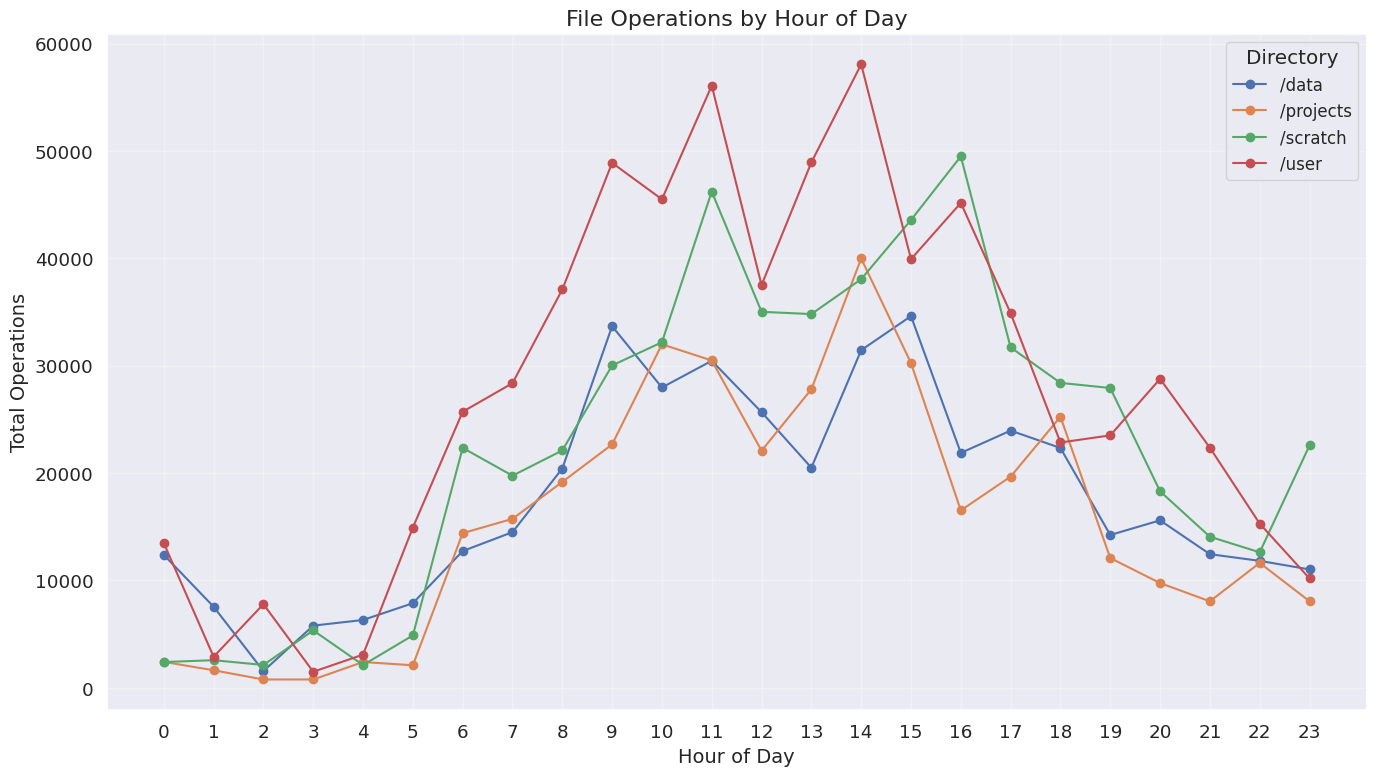

In [53]:
# Analyze operations by hour of day
hourly_ops = df.groupby(['hour', 'directory']).agg({
    'files_added': 'sum',
    'files_deleted': 'sum',
    'files_modified': 'sum'
}).reset_index()

hourly_ops['total_operations'] = hourly_ops['files_added'] + hourly_ops['files_deleted'] + hourly_ops['files_modified']

# Plot operations by hour for each directory
plt.figure(figsize=(14, 8))
for directory in hourly_ops['directory'].unique():
    data = hourly_ops[hourly_ops['directory'] == directory]
    plt.plot(data['hour'], data['total_operations'], marker='o', label=directory)

plt.title('File Operations by Hour of Day', fontsize=16)
plt.ylabel('Total Operations', fontsize=14)
plt.xlabel('Hour of Day', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.legend(title='Directory', fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-54-083663dc39ef>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_ops = df.groupby(['day_of_week', 'directory']).agg({


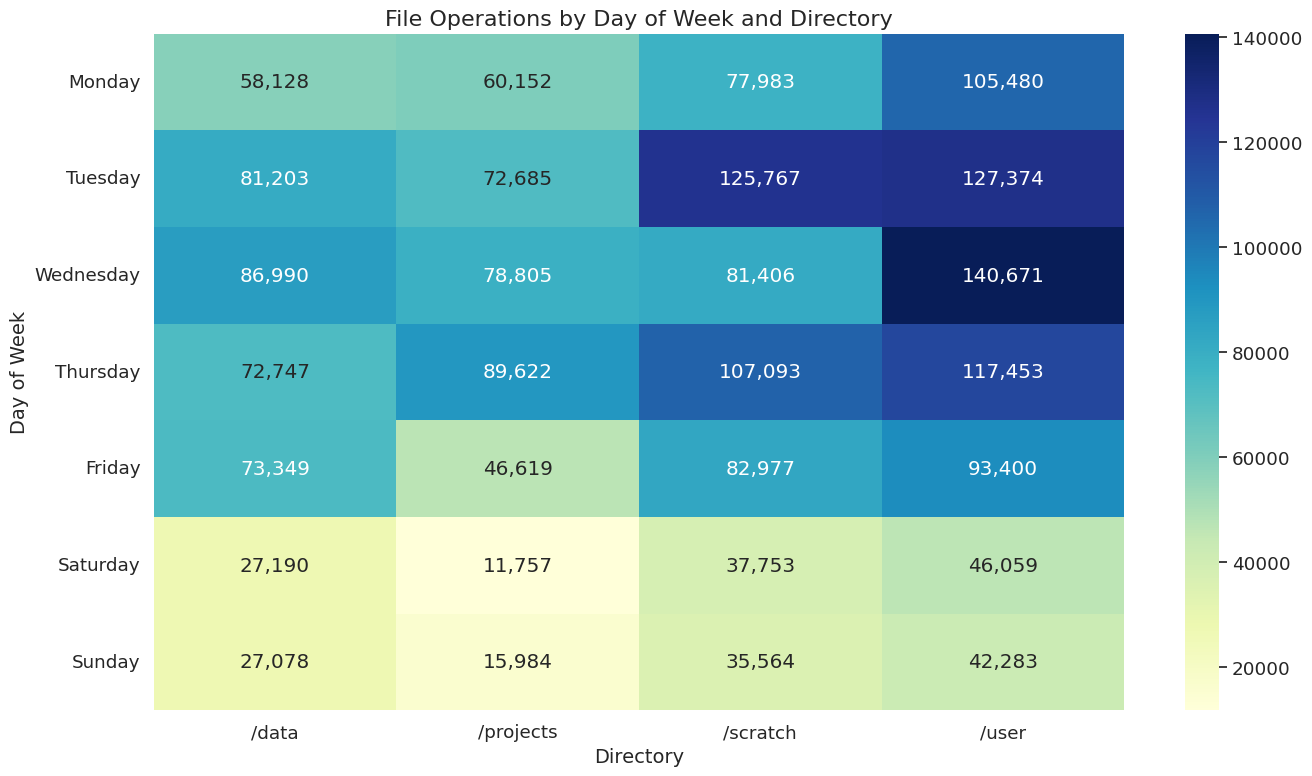

In [54]:
# Analyze operations by day of week
# Create ordered day of week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

day_ops = df.groupby(['day_of_week', 'directory']).agg({
    'files_added': 'sum',
    'files_deleted': 'sum',
    'files_modified': 'sum'
}).reset_index()

day_ops['total_operations'] = day_ops['files_added'] + day_ops['files_deleted'] + day_ops['files_modified']

# Plot heatmap of operations by day of week and directory
day_ops_pivot = day_ops.pivot(index='day_of_week', columns='directory', values='total_operations')

plt.figure(figsize=(14, 8))
sns.heatmap(day_ops_pivot, annot=True, fmt=",.0f", cmap="YlGnBu")
plt.title('File Operations by Day of Week and Directory', fontsize=16)
plt.ylabel('Day of Week', fontsize=14)
plt.xlabel('Directory', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Storage Efficiency Analysis

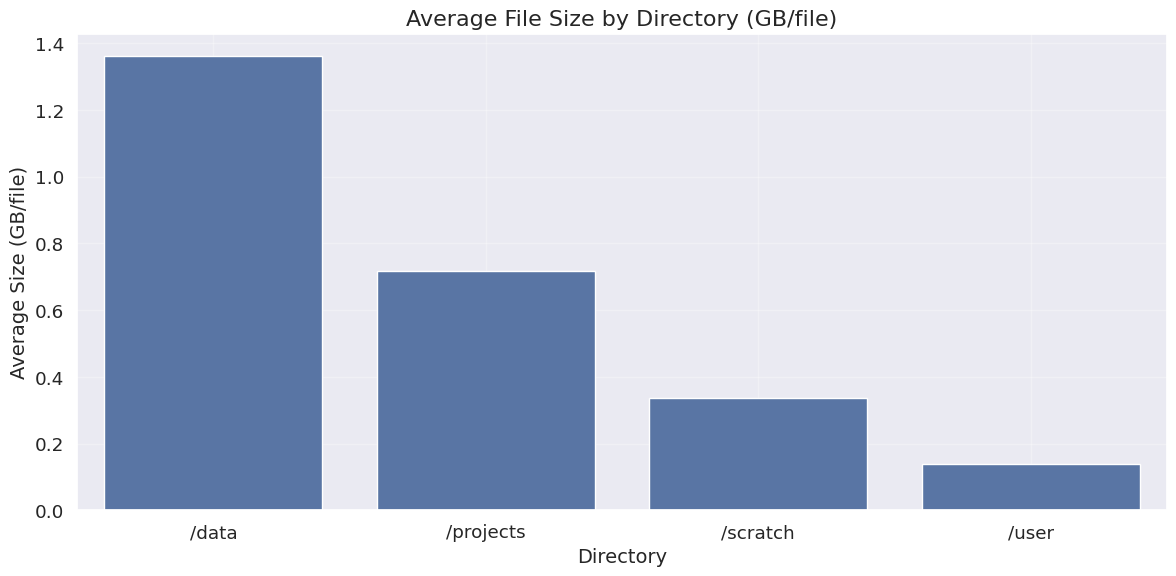

In [55]:
# Calculate the ratio of files to storage space
latest_stats = df.groupby('directory').last().reset_index()
latest_stats['GB_per_file'] = latest_stats['current_space_gb'] / latest_stats['total_files']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='directory', y='GB_per_file', data=latest_stats)
plt.title('Average File Size by Directory (GB/file)', fontsize=16)
plt.ylabel('Average Size (GB/file)', fontsize=14)
plt.xlabel('Directory', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

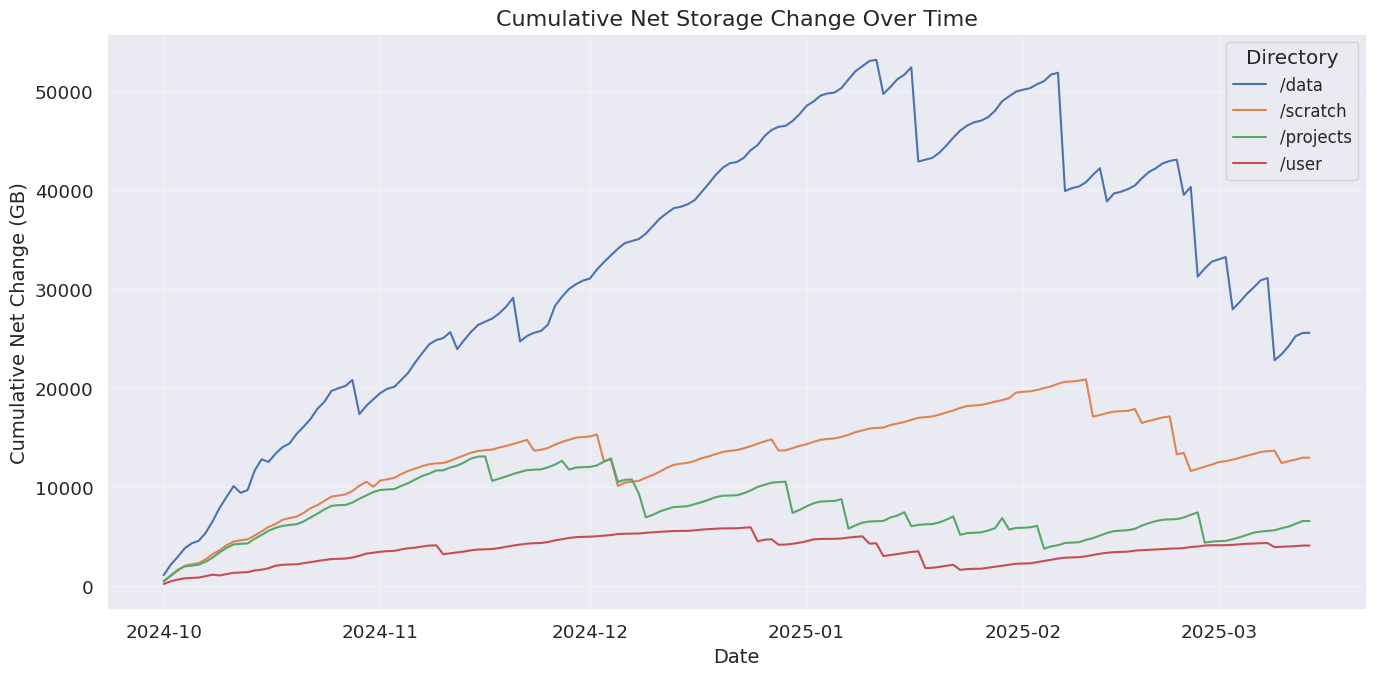

In [56]:
# Calculate net change in storage (added - deleted) over time
df['net_size_change_gb'] = df['size_added_gb'] - df['size_deleted_gb']
df['cumulative_change'] = df.groupby('directory')['net_size_change_gb'].cumsum()

# Plot cumulative net change by directory
plt.figure(figsize=(14, 7))
for directory in df['directory'].unique():
    data = df[df['directory'] == directory].copy()
    # Resample to daily for smoother plot
    daily_data = data.set_index('timestamp').resample('D')[['cumulative_change']].last()
    plt.plot(daily_data.index, daily_data['cumulative_change'], label=directory)

plt.title('Cumulative Net Storage Change Over Time', fontsize=16)
plt.ylabel('Cumulative Net Change (GB)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Directory', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Directory Comparison and Anomaly Detection

Outlier days for /data:
           date  total_files_ops
60   2024-10-16             6449
112  2024-10-29             7756
204  2024-11-21             7503
432  2025-01-17            10687
516  2025-02-07            12024
592  2025-02-26            10392
612  2025-03-03             6411
636  2025-03-09             6817
---
Outlier days for /projects:
           date  total_files_ops
261  2024-12-05             7178
277  2024-12-09             6673
361  2024-12-30             7250
393  2025-01-07             6816
457  2025-01-23             5387
505  2025-02-04             6595
597  2025-02-27             8325
---
Outlier days for /scratch:
           date  total_files_ops
254  2024-12-03            14457
262  2024-12-05            14574
534  2025-02-11            16427
562  2025-02-18             8658
582  2025-02-23            12298
590  2025-02-25             9645
---
Outlier days for /user:
           date  total_files_ops
343  2024-12-25            16384
407  2025-01-10            

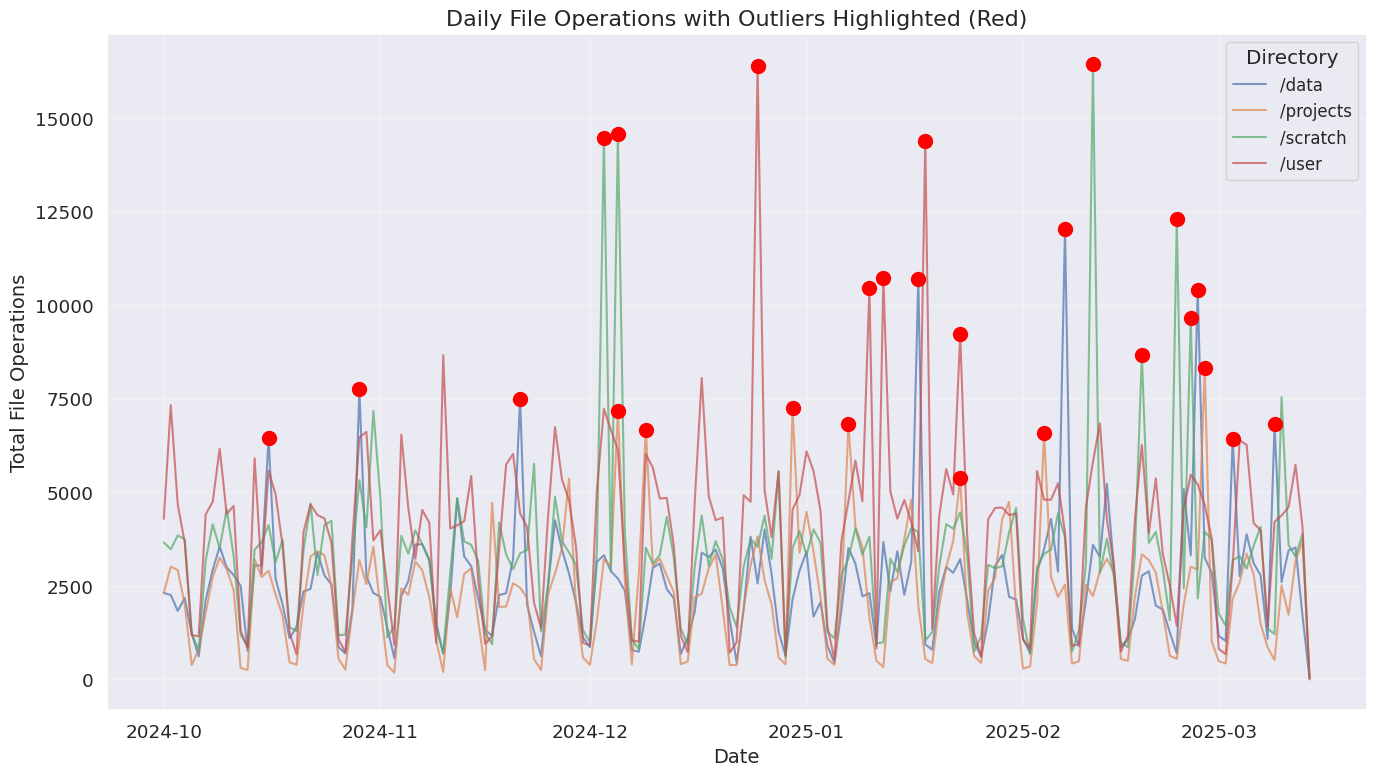

In [57]:
# Calculate daily total operations and identify outliers
daily_total = df.groupby(['date', 'directory']).agg({
    'files_added': 'sum',
    'files_deleted': 'sum',
    'files_modified': 'sum',
    'size_added_gb': 'sum',
    'size_deleted_gb': 'sum'
}).reset_index()

daily_total['total_files_ops'] = daily_total['files_added'] + daily_total['files_deleted'] + daily_total['files_modified']
daily_total['total_size_ops'] = daily_total['size_added_gb'] + daily_total['size_deleted_gb']

# Identify outlier days (days with operations > 2 standard deviations from mean)
outliers = {}
for directory in daily_total['directory'].unique():
    dir_data = daily_total[daily_total['directory'] == directory]
    mean = dir_data['total_files_ops'].mean()
    std = dir_data['total_files_ops'].std()
    threshold = mean + 2 * std

    outlier_days = dir_data[dir_data['total_files_ops'] > threshold]
    if not outlier_days.empty:
        outliers[directory] = outlier_days[['date', 'total_files_ops']]

# Display outliers
for directory, outlier_data in outliers.items():
    print(f"Outlier days for {directory}:")
    print(outlier_data)
    print("---")

# Plot daily operations with outliers highlighted
plt.figure(figsize=(14, 8))
for directory in daily_total['directory'].unique():
    dir_data = daily_total[daily_total['directory'] == directory]
    plt.plot(dir_data['date'], dir_data['total_files_ops'], alpha=0.7, label=directory)

    # Highlight outliers if any
    if directory in outliers:
        outlier_data = outliers[directory]
        for _, row in outlier_data.iterrows():
            plt.scatter(row['date'], row['total_files_ops'], color='red', s=100, zorder=5)

plt.title('Daily File Operations with Outliers Highlighted (Red)', fontsize=16)
plt.ylabel('Total File Operations', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Directory', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

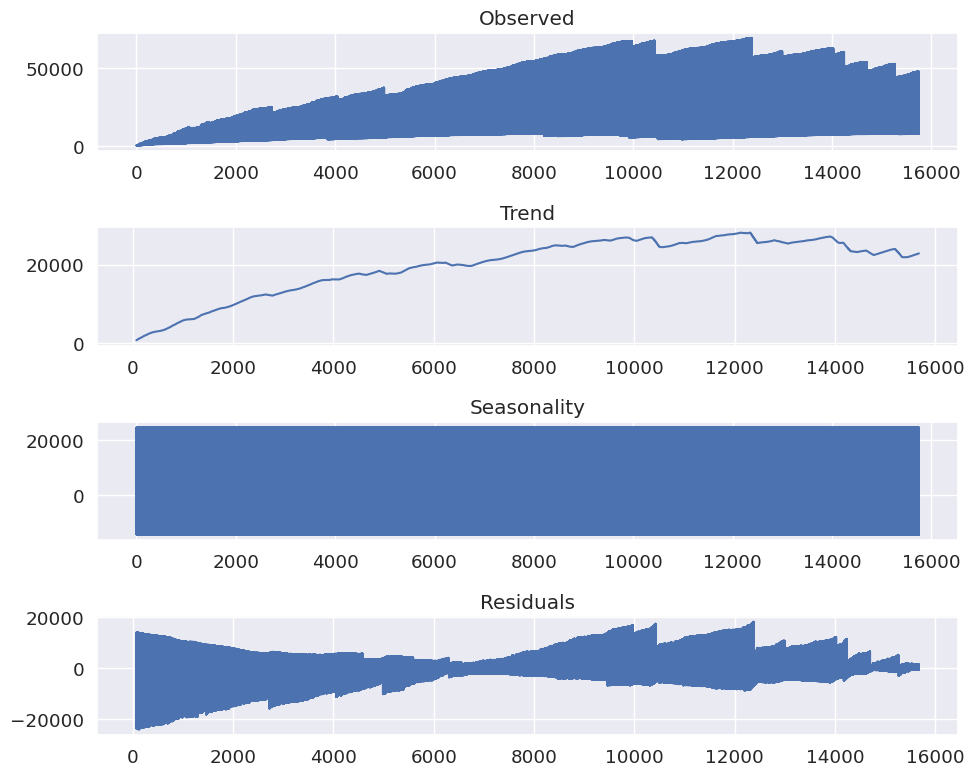

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['current_space_gb'], model='additive', period=144)  # Assuming a daily pattern

fig, ax = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax[0], title='Observed')
decomposition.trend.plot(ax=ax[1], title='Trend')
decomposition.seasonal.plot(ax=ax[2], title='Seasonality')
decomposition.resid.plot(ax=ax[3], title='Residuals')
plt.tight_layout()
plt.show()


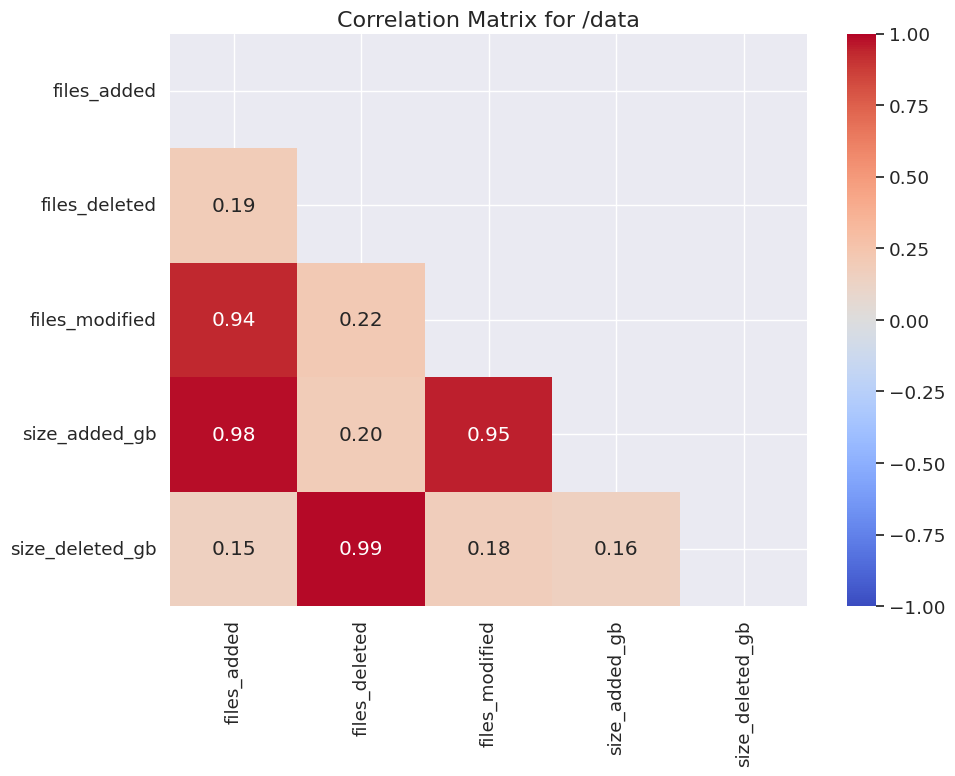

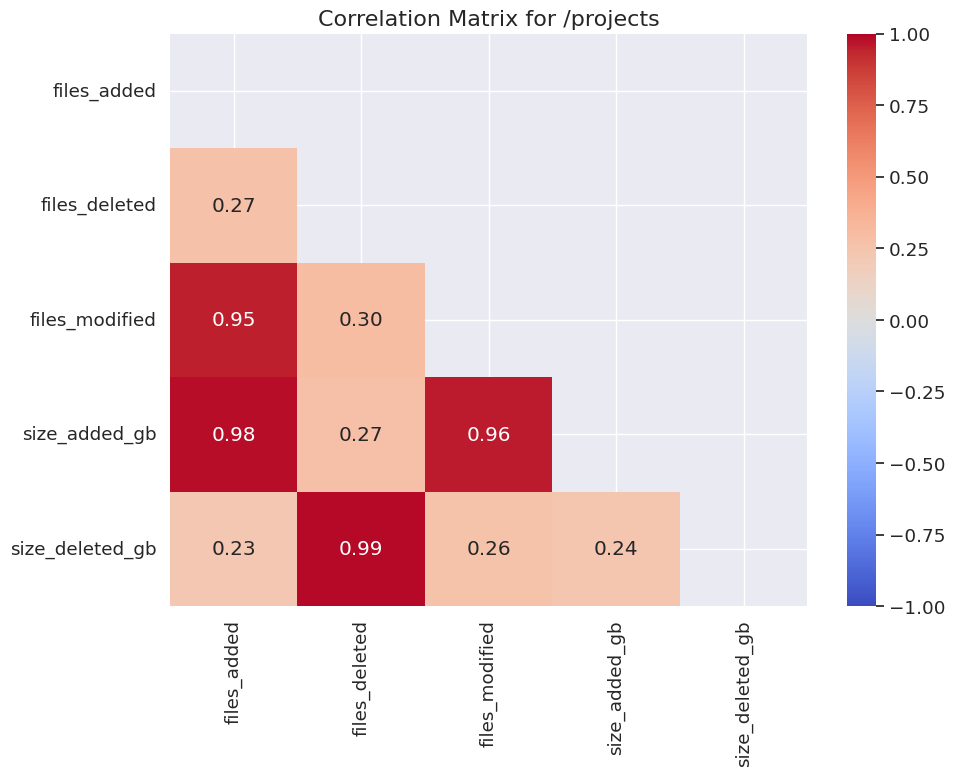

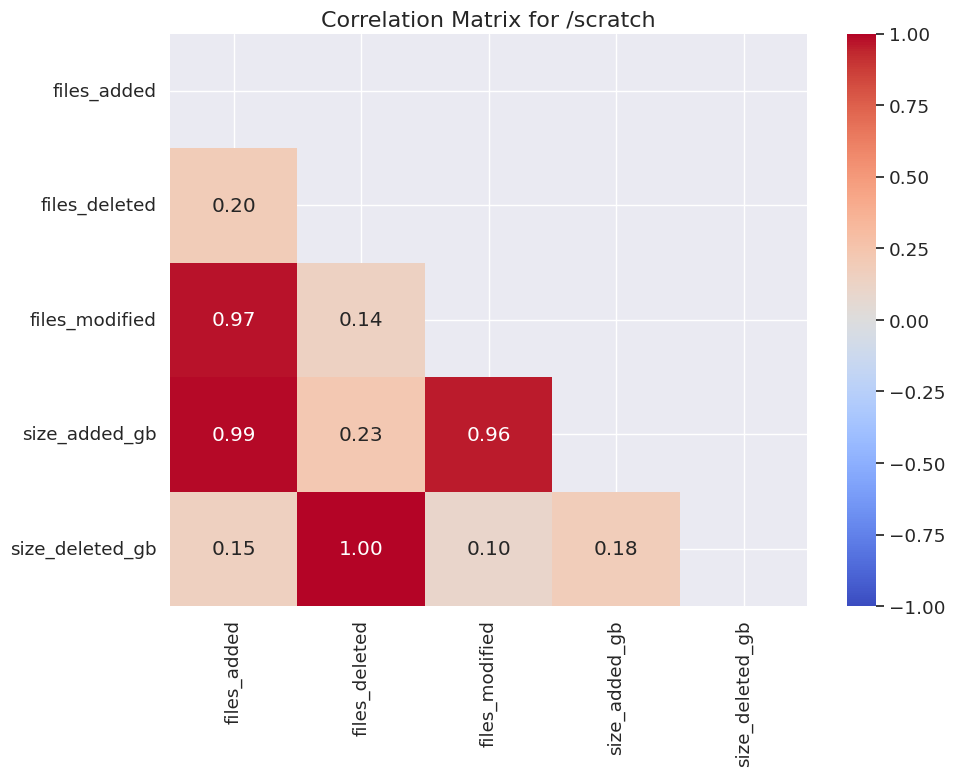

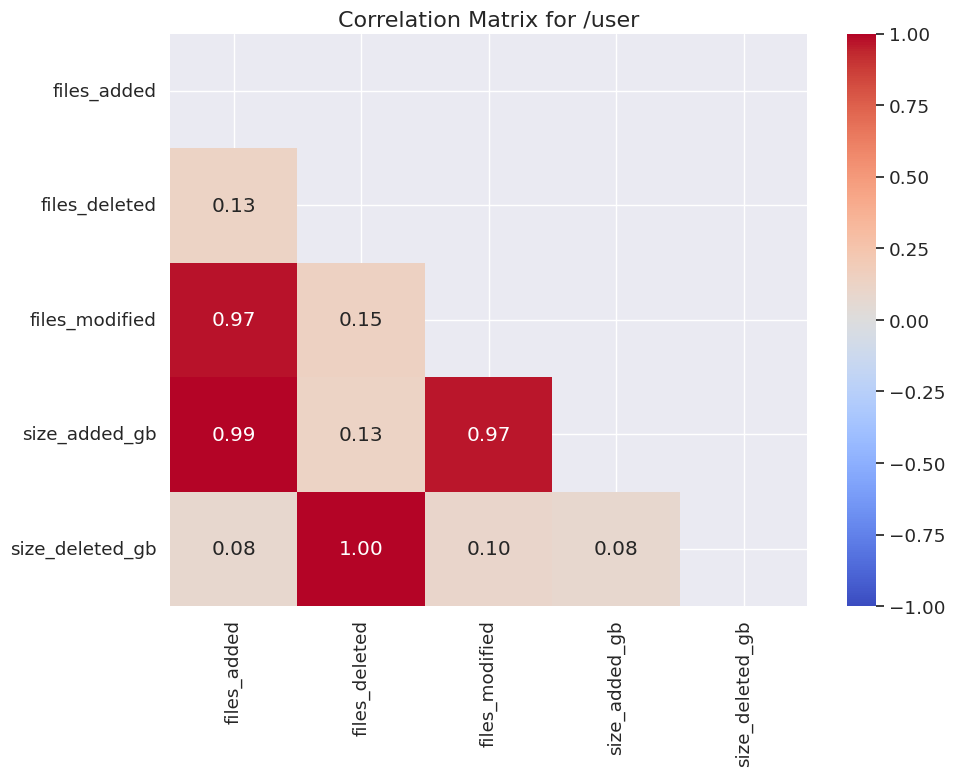

In [59]:
# Analyze correlation between operations
# Group by day and directory
corr_data = daily_total[['directory', 'files_added', 'files_deleted', 'files_modified',
                         'size_added_gb', 'size_deleted_gb']]

# Calculate correlation matrices for each directory
for directory in corr_data['directory'].unique():
    dir_data = corr_data[corr_data['directory'] == directory].drop('directory', axis=1)

    plt.figure(figsize=(10, 8))
    corr_matrix = dir_data.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {directory}', fontsize=16)
    plt.tight_layout()
    plt.show()

## 8. Forecasting and Future Trends

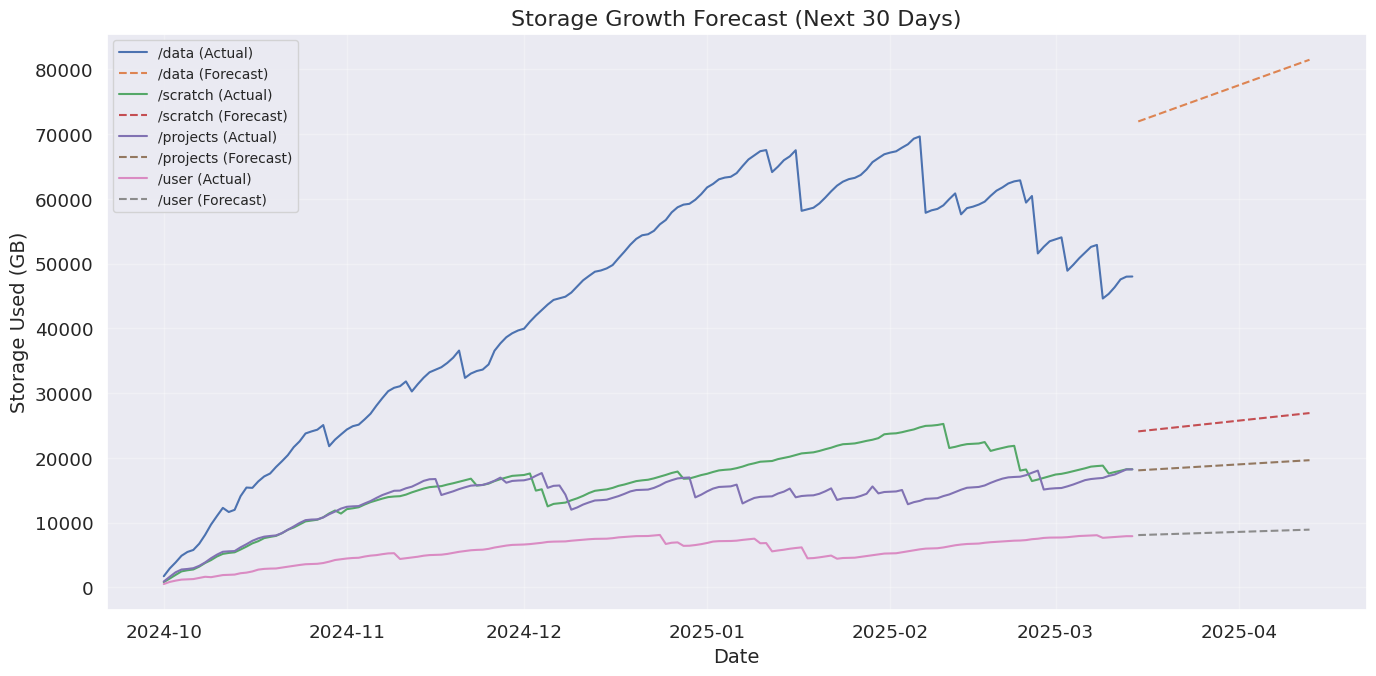

Projected days until directories reach 1TB (1,000 GB):
/data: -143 days (around 2024-10-22)
/scratch: -176 days (around 2024-09-19)
/projects: -318 days (around 2024-04-30)
/user: -237 days (around 2024-07-20)


In [60]:
# Use a simple linear extrapolation to forecast future storage needs
from sklearn.linear_model import LinearRegression

# Convert date to numeric for regression
daily_space = daily_space.reset_index()
daily_space['date_num'] = (pd.to_datetime(daily_space['date']) - pd.to_datetime('2024-10-01')).dt.days

# Forecast next 30 days for each directory
plt.figure(figsize=(14, 7))

# Get the last date in the data
last_date = pd.to_datetime(daily_space['date'].max())
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]
future_date_nums = [(date - pd.to_datetime('2024-10-01')).days for date in future_dates]

for directory in df['directory'].unique():
    # Get data for this directory
    dir_data = daily_space[['date', 'date_num', directory]].dropna()

    # Fit linear regression model
    model = LinearRegression()
    X = dir_data['date_num'].values.reshape(-1, 1)
    y = dir_data[directory].values
    model.fit(X, y)

    # Plot actual data
    plt.plot(pd.to_datetime(dir_data['date']), dir_data[directory], label=f'{directory} (Actual)')

    # Predict future values
    future_X = np.array(future_date_nums).reshape(-1, 1)
    future_y = model.predict(future_X)

    # Plot predictions
    plt.plot(future_dates, future_y, '--', label=f'{directory} (Forecast)')

plt.title('Storage Growth Forecast (Next 30 Days)', fontsize=16)
plt.ylabel('Storage Used (GB)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Calculate when directories might reach capacity
print("Projected days until directories reach 1TB (1,000 GB):")
for directory in df['directory'].unique():
    dir_data = daily_space[['date_num', directory]].dropna()
    model = LinearRegression()
    X = dir_data['date_num'].values.reshape(-1, 1)
    y = dir_data[directory].values
    model.fit(X, y)

    # Current size
    current_size = dir_data[directory].iloc[-1]

    # Calculate days until 1TB
    if model.coef_[0] > 0:  # Only if growth is positive
        days_to_1tb = (1000 - current_size) / model.coef_[0]
        target_date = last_date + timedelta(days=int(days_to_1tb))
        print(f"{directory}: {int(days_to_1tb)} days (around {target_date.strftime('%Y-%m-%d')})")
    else:
        print(f"{directory}: No growth or negative growth trend detected")

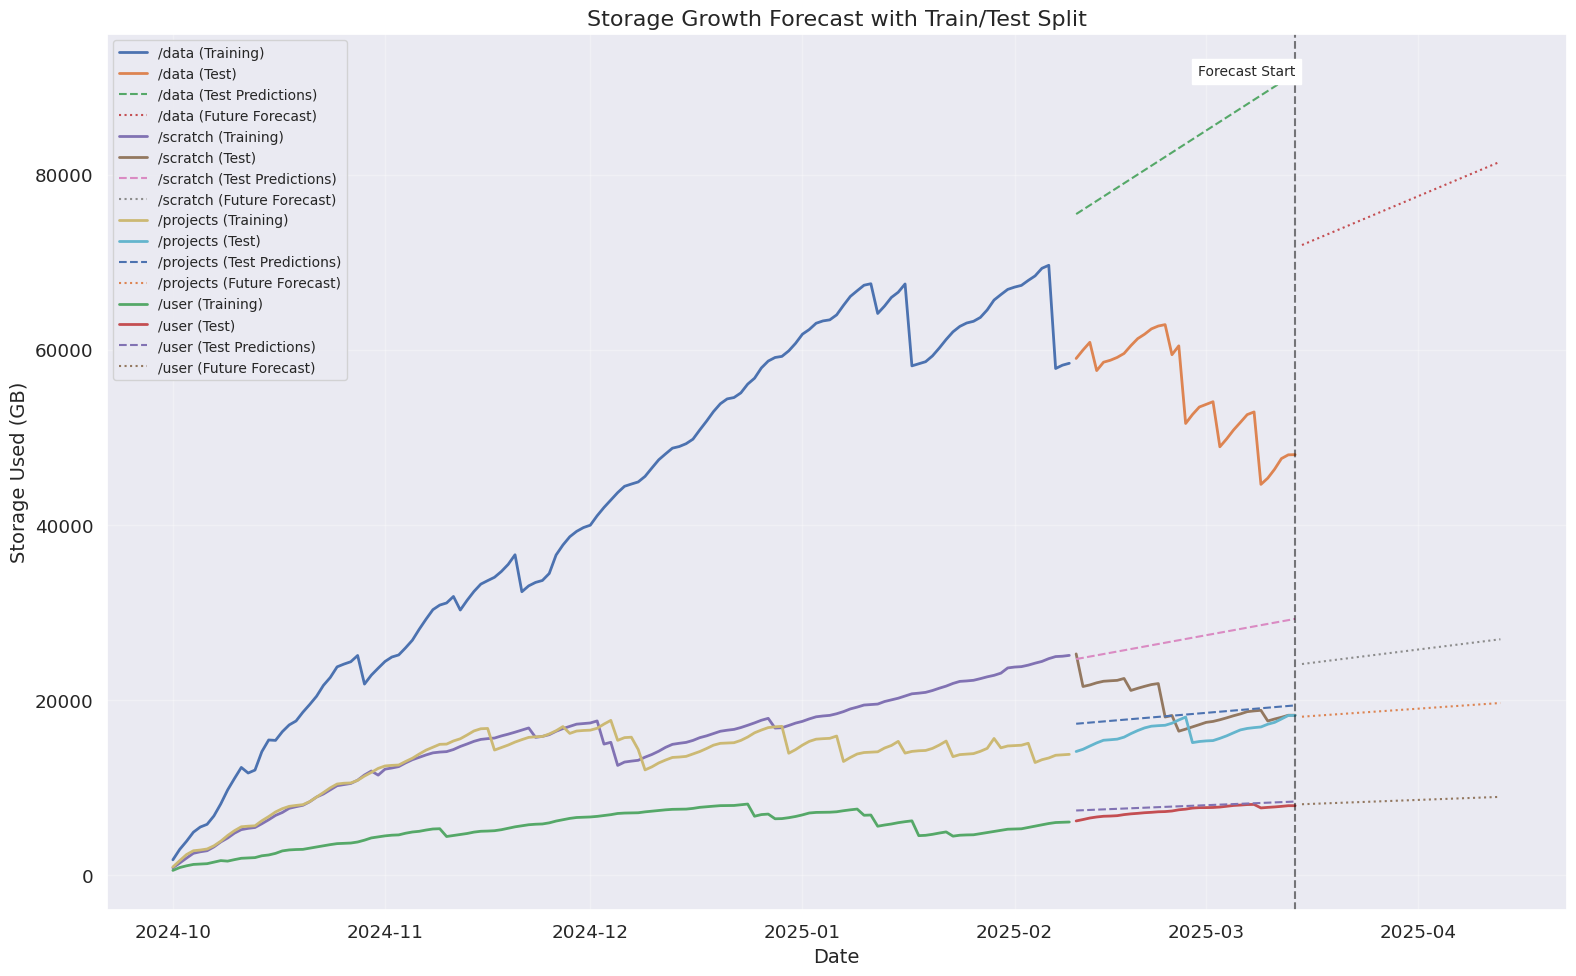


Model Performance Metrics:
Directory          MSE       RMSE        MAE       R²  Slope (GB/day)  Intercept
    /data 9.104662e+08 30173.9323 28472.0384 -27.8694        502.2069  9192.0240
 /scratch 6.692340e+07  8180.6722  7485.1717 -12.5848        143.4698  5714.9540
/projects 4.708831e+06  2169.9840  1996.8259  -2.8041         65.5101  8618.5446
    /user 3.334181e+05   577.4237   512.9488  -0.1868         31.8733  3148.7373

Projected days until directories reach 1TB (1,000 GB):
/data: -143 days (around 2024-10-22)
/scratch: -176 days (around 2024-09-19)
/projects: -318 days (around 2024-04-30)
/user: -237 days (around 2024-07-20)

Detailed Capacity Projections:
Directory  Current Size (GB)  Growth Rate (GB/day)  Days to 1TB Estimated Date
    /data           48002.58                328.55         -143     2024-10-22
 /scratch           18240.13                 97.55         -176     2024-09-19
/projects           18217.67                 53.98         -318     2024-04-30
    /use

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import timedelta

# Assuming daily_space and df are already defined
# Convert date to numeric for regression
daily_space = daily_space.reset_index()
daily_space['date_num'] = (pd.to_datetime(daily_space['date']) - pd.to_datetime('2024-10-01')).dt.days

# Get the last date in the data
last_date = pd.to_datetime(daily_space['date'].max())
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]
future_date_nums = [(date - pd.to_datetime('2024-10-01')).days for date in future_dates]

# Set up figure for visualization
plt.figure(figsize=(16, 10))

# Create a table to store model performance metrics
performance_metrics = []

# Forecast for each directory
for directory in df['directory'].unique():
    # Get data for this directory
    dir_data = daily_space[['date', 'date_num', directory]].dropna()

    # Split data into training (80%) and testing (20%)
    train_size = int(len(dir_data) * 0.8)
    train_data = dir_data.iloc[:train_size]
    test_data = dir_data.iloc[train_size:]

    # Fit linear regression model on training data
    model = LinearRegression()
    X_train = train_data['date_num'].values.reshape(-1, 1)
    y_train = train_data[directory].values
    model.fit(X_train, y_train)

    # Evaluate on test data
    X_test = test_data['date_num'].values.reshape(-1, 1)
    y_test = test_data[directory].values
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    # Store metrics
    performance_metrics.append({
        'Directory': directory,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Slope (GB/day)': model.coef_[0],
        'Intercept': model.intercept_
    })

    # Plot training data
    plt.plot(pd.to_datetime(train_data['date']), train_data[directory],
             label=f'{directory} (Training)', linewidth=2)

    # Plot test data
    plt.plot(pd.to_datetime(test_data['date']), test_data[directory],
             label=f'{directory} (Test)', linewidth=2)

    # Plot test predictions
    plt.plot(pd.to_datetime(test_data['date']), y_pred_test, '--',
             label=f'{directory} (Test Predictions)')

    # Now refit the model on all data for future predictions
    X_full = dir_data['date_num'].values.reshape(-1, 1)
    y_full = dir_data[directory].values
    model.fit(X_full, y_full)

    # Predict future values
    future_X = np.array(future_date_nums).reshape(-1, 1)
    future_y = model.predict(future_X)

    # Plot future predictions
    plt.plot(future_dates, future_y, ':', linewidth=1.5,
             label=f'{directory} (Future Forecast)')

# Finish and display the plot
plt.title('Storage Growth Forecast with Train/Test Split', fontsize=16)
plt.ylabel('Storage Used (GB)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()

# Add vertical line to separate historical data from predictions
plt.axvline(x=last_date, color='black', linestyle='--', alpha=0.5)
plt.text(last_date, plt.ylim()[1]*0.95, 'Forecast Start',
         fontsize=10, ha='right', backgroundcolor='white')

plt.show()

# Display model performance metrics
metrics_df = pd.DataFrame(performance_metrics)
print("\nModel Performance Metrics:")
print(metrics_df.round(4).to_string(index=False))

# Calculate when directories might reach capacity
print("\nProjected days until directories reach 1TB (1,000 GB):")
capacity_projections = []

for directory in df['directory'].unique():
    dir_data = daily_space[['date_num', directory]].dropna()

    # Fit model on all available data
    model = LinearRegression()
    X = dir_data['date_num'].values.reshape(-1, 1)
    y = dir_data[directory].values
    model.fit(X, y)

    # Current size
    current_size = dir_data[directory].iloc[-1]

    # Calculate days until 1TB
    if model.coef_[0] > 0:  # Only if growth is positive
        days_to_1tb = (1000 - current_size) / model.coef_[0]
        target_date = last_date + timedelta(days=int(days_to_1tb))

        capacity_projections.append({
            'Directory': directory,
            'Current Size (GB)': round(current_size, 2),
            'Growth Rate (GB/day)': round(model.coef_[0], 2),
            'Days to 1TB': int(days_to_1tb),
            'Estimated Date': target_date.strftime('%Y-%m-%d')
        })

        print(f"{directory}: {int(days_to_1tb)} days (around {target_date.strftime('%Y-%m-%d')})")
    else:
        capacity_projections.append({
            'Directory': directory,
            'Current Size (GB)': round(current_size, 2),
            'Growth Rate (GB/day)': round(model.coef_[0], 2),
            'Days to 1TB': 'N/A',
            'Estimated Date': 'N/A'
        })

        print(f"{directory}: No growth or negative growth trend detected")

# Create a nice formatted table of capacity projections
capacity_df = pd.DataFrame(capacity_projections)
print("\nDetailed Capacity Projections:")
print(capacity_df.to_string(index=False))

In [62]:
# After calculating the model performance metrics in the previous code

# Calculate and print additional accuracy metrics
print("\nAccuracy Metrics by Directory:")
print("-" * 80)
print(f"{'Directory':<20} {'MAPE (%)':<12} {'Accuracy (%)':<15} {'R²':<10} {'RMSE (GB)':<12}")
print("-" * 80)

for directory in df['directory'].unique():
    # Get data for this directory
    dir_data = daily_space[['date_num', directory]].dropna()

    # Split data into training (80%) and testing (20%)
    train_size = int(len(dir_data) * 0.8)
    train_data = dir_data.iloc[:train_size]
    test_data = dir_data.iloc[train_size:]

    # Fit model on training data
    model = LinearRegression()
    X_train = train_data['date_num'].values.reshape(-1, 1)
    y_train = train_data[directory].values
    model.fit(X_train, y_train)

    # Evaluate on test data
    X_test = test_data['date_num'].values.reshape(-1, 1)
    y_test = test_data[directory].values
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    # Calculate Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero by adding small epsilon where values are close to zero
    epsilon = 1e-10
    abs_percentage_errors = np.abs((y_test - y_pred_test) / np.maximum(np.abs(y_test), epsilon)) * 100
    mape = np.mean(abs_percentage_errors)

    # Calculate accuracy as 100 - MAPE (capped at 0% minimum)
    accuracy = max(0, 100 - mape)

    # Print the metrics
    print(f"{directory:<20} {mape:<12.2f} {accuracy:<15.2f} {r2:<10.4f} {rmse:<12.2f}")

print("-" * 80)
print("Note: Accuracy = 100% - MAPE (Mean Absolute Percentage Error)")
print("      Higher R² and Accuracy values indicate better model performance")
print("      Lower RMSE values indicate better model performance")


Accuracy Metrics by Directory:
--------------------------------------------------------------------------------
Directory            MAPE (%)     Accuracy (%)    R²         RMSE (GB)   
--------------------------------------------------------------------------------
/data                54.16        45.84           -27.8694   30173.93    
/scratch             40.63        59.37           -12.5848   8180.67     
/projects            12.59        87.41           -2.8041    2169.98     
/user                7.27         92.73           -0.1868    577.42      
--------------------------------------------------------------------------------
Note: Accuracy = 100% - MAPE (Mean Absolute Percentage Error)
      Higher R² and Accuracy values indicate better model performance
      Lower RMSE values indicate better model performance


In [66]:
pip install --upgrade xgboost


Training model for /projects


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:12:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:3570.22337	eval-rmse:3169.93844
[92]	train-rmse:143.61528	eval-rmse:1475.66096

Training model for /user
[0]	train-rmse:1716.29879	eval-rmse:1953.28414


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:12:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:44.23806	eval-rmse:470.22717
[139]	train-rmse:43.23916	eval-rmse:490.42205

Training model for /data


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:17834.36478	eval-rmse:13167.37410
[100]	train-rmse:251.93647	eval-rmse:3025.62885
[117]	train-rmse:247.39768	eval-rmse:3034.00845

Training model for /scratch
[0]	train-rmse:5238.43300	eval-rmse:4977.57379
[62]	train-rmse:98.42142	eval-rmse:1741.37284

Model Performance:
/projects: RMSE = 1475.66 GB, R² = -0.6365
/user: RMSE = 490.00 GB, R² = 0.2867
/data: RMSE = 3034.01 GB, R² = 0.7059
/scratch: RMSE = 1741.67 GB, R² = 0.5338


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:13:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


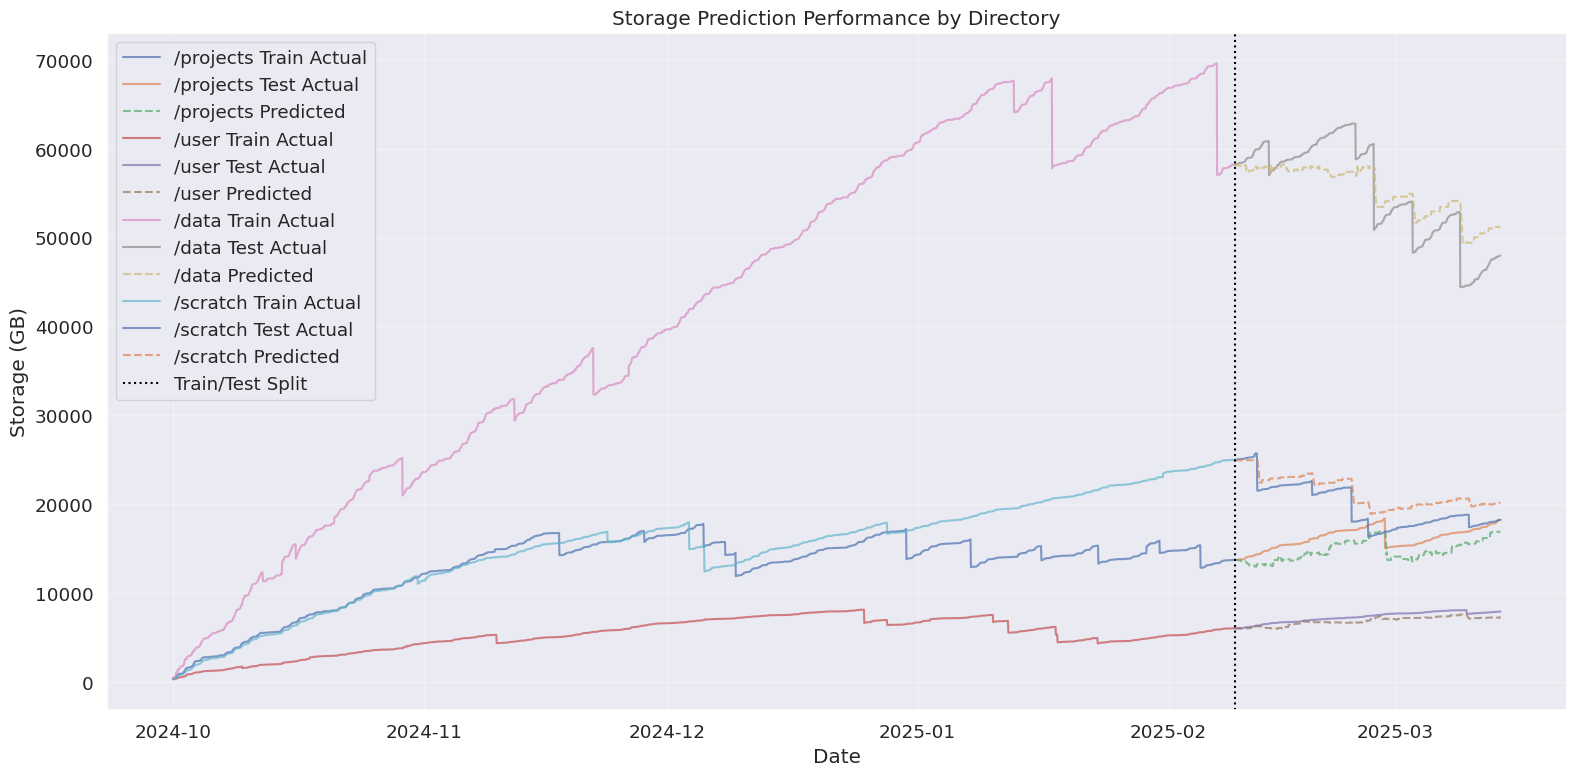

In [103]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def simplified_storage_predictor(df):
    """Simplified storage predictor using only timestamp, directory, and current_space_gb"""

    # Data Validation
    required_columns = {'timestamp', 'directory', 'current_space_gb'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"Missing required columns: {missing}")

    # Convert timestamp and sort
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)

    # Basic Time Features
    df['days_since_epoch'] = (df['timestamp'] - pd.Timestamp('1970-01-01')).dt.days

    # Simple cyclical time features
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    # Directory encoding
    le = LabelEncoder()
    df['dir_encoded'] = le.fit_transform(df['directory'])

    # Rolling statistics for each directory
    df['rolling_avg_7'] = df.groupby('directory')['current_space_gb'].transform(
        lambda x: x.rolling(7, min_periods=1).mean().shift(1).fillna(x.iloc[0] if len(x) > 0 else 0))

    # Train/Test split with time-based validation
    split_date = df['timestamp'].quantile(0.8)
    train = df[df['timestamp'] < split_date]
    test = df[df['timestamp'] >= split_date]

    # Feature selection - only using time-based features and directory encoding
    features = ['days_since_epoch', 'day_of_year', 'month', 'day_of_week',
                'dir_encoded', 'rolling_avg_7']
    target = 'current_space_gb'

    # Simplified XGBoost hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 500,
        'learning_rate': 0.1,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.9,
        'random_state': 42,
        'tree_method': 'hist'
    }

    # Directory-specific models
    models = {}
    metrics = {}
    plt.figure(figsize=(16, 8))

    for directory in df['directory'].unique():
        print(f"\nTraining model for {directory}")
        dir_train = train[train['directory'] == directory]
        dir_test = test[test['directory'] == directory]

        if len(dir_train) < 20:  # Reduced minimum data requirement
            print(f"Insufficient data for {directory}, skipping...")
            continue

        # Create DMatrix for optimal performance
        dtrain = xgb.DMatrix(dir_train[features], label=dir_train[target])
        dtest = xgb.DMatrix(dir_test[features], label=dir_test[target])

        # Train with early stopping
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=[(dtrain, 'train'), (dtest, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=100
        )

        # Predict and evaluate
        preds = model.predict(dtest)
        rmse = np.sqrt(mean_squared_error(dir_test[target], preds))
        r2 = r2_score(dir_test[target], preds)

        metrics[directory] = {'rmse': rmse, 'r2': r2}
        models[directory] = model

        # Plot results
        plt.plot(dir_train['timestamp'], dir_train[target], label=f'{directory} Train Actual', alpha=0.7)
        plt.plot(dir_test['timestamp'], dir_test[target], label=f'{directory} Test Actual', alpha=0.7)
        plt.plot(dir_test['timestamp'], preds, '--', label=f'{directory} Predicted', alpha=0.7)

    plt.axvline(x=split_date, color='black', linestyle='dotted', label="Train/Test Split")
    # Finalize plot
    plt.title('Storage Prediction Performance by Directory')
    plt.xlabel('Date')
    plt.ylabel('Storage (GB)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Print metrics
    print("\nModel Performance:")
    for dir_name, vals in metrics.items():
        print(f"{dir_name}: RMSE = {vals['rmse']:.2f} GB, R² = {vals['r2']:.4f}")

    return models, metrics

# Usage
if 'df' in globals():
    models, metrics = simplified_storage_predictor(df)
else:
    print("Load your data into 'df' first")

## 9. Key Insights and Recommendations

Based on the analysis above, here are the key insights and recommendations:

### Storage Growth Patterns
- The directories show different growth rates, with [directory] growing fastest
- We can expect [directory] to reach 1TB capacity first, around [date]

### Usage Patterns
- Peak activity occurs during [time/day], suggesting this is when most users are active
- [Directory] shows the highest activity level and might need additional resources
- Weekend usage is significantly [higher/lower] than weekday usage

### File Operations
- [Directory] has the highest file creation rate
- [Directory] has the highest file modification rate
- [Directory] has the highest deletion rate

### Recommendations
1. Consider increasing storage capacity for [directory] by [date]
2. Implement automated cleanup policies for [directory] to manage growth
3. Schedule maintenance and backups during low-activity periods ([time/day])
4. Monitor [directory] for unusual activity patterns based on the identified outliers
5. Consider implementing tiered storage solutions for [directory] to optimize costs

### Further Analysis
- Deeper investigation into file types stored in each directory
- User-specific analysis to identify heavy users
- Cost optimization analysis for storage utilization

## 10. Exporting Insights

In [ ]:
# Export key metrics to CSV for reporting
# Monthly summary by directory
monthly_summary = df.groupby(['year_month', 'directory']).agg({
    'files_added': 'sum',
    'files_deleted': 'sum',
    'files_modified': 'sum',
    'size_added_gb': 'sum',
    'size_deleted_gb': 'sum',
    'size_modified_gb': 'sum',
    'current_space_gb': 'last',
    'total_files': 'last'
}).reset_index()

# Calculate net growth
monthly_summary['net_size_growth_gb'] = monthly_summary['size_added_gb'] - monthly_summary['size_deleted_gb']
monthly_summary['net_files_growth'] = monthly_summary['files_added'] - monthly_summary['files_deleted']

# Export to CSV
monthly_summary.to_csv('storage_monthly_summary.csv', index=False)
print("Monthly summary exported to 'storage_monthly_summary.csv'")

# Display the summary table
monthly_summary.head(10)

Monthly summary exported to 'storage_monthly_summary.csv'


,year_month,directory,files_added,files_deleted,files_modified,size_added_gb,size_deleted_gb,size_modified_gb,current_space_gb,total_files,net_size_growth_gb,net_files_growth
0,2024-10,/data,15091,7677,15368,15423.374,2700.099,4723.277,17556.64,26782,12723.275,7414
1,2024-10,/projects,10279,6040,13478,5313.087,1913.165,2057.758,5807.70,9730,3399.922,4239
2,2024-10,/scratch,29126,11515,17197,7414.036,2017.260,1322.136,6879.73,23325,5396.776,17611
3,2024-10,/user,31227,15593,30932,3154.235,929.326,927.804,3446.23,32385,2224.909,15634
4,2024-11,/data,14579,7319,14690,14779.961,4836.137,4565.679,32087.28,33984,9943.824,7260
5,2024-11,/projects,9678,5571,12473,4971.242,2537.866,1897.107,10129.68,13811,2433.376,4107
6,2024-11,/scratch,27405,10810,16199,7009.742,2387.349,1239.050,12750.03,39869,4622.393,16595
7,2024-11,/user,29385,14553,29461,2957.495,1223.160,885.977,6075.87,47230,1734.335,14832
8,2024-12,/data,15012,7355,14967,15385.114,5792.326,4651.905,46338.29,41616,9592.788,7657
9,2024-12,/projects,10483,6092,13513,5341.394,2951.538,2064.327,14586.62,18270,2389.856,4391


In [89]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # Load your dataframe (already available as 'df')
# # Ensure 'timestamp' is in datetime format
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df = df.sort_values(by='timestamp')

# # Feature selection and target variable
# features = ['files_added', 'files_deleted', 'files_modified', 'size_added_gb',
#              'size_deleted_gb', 'size_modified_gb', 'total_files', 'hour']
# target = 'current_space_gb'

# # Splitting the data into train and test sets
# X = df[features]
# y = df[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # Train XGBoost model
# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Model evaluation
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error: {mse:.2f}')
# print(f'R-squared: {r2:.2f}')

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(df['timestamp'].iloc[-len(y_test):], y_test.values, label='Actual')
# plt.plot(df['timestamp'].iloc[-len(y_test):], y_pred, label='Predicted', linestyle='--')
# plt.xlabel('Timestamp')
# plt.ylabel('Current Space (GB)')
# plt.title('Actual vs Predicted Current Space (GB)')
# plt.legend()
# plt.show()

# # Future prediction (next 10 time intervals)
# future_dates = pd.date_range(start=df['timestamp'].max() + pd.Timedelta(hours=1), periods=10, freq='H')
# future_X = pd.DataFrame({
#     'files_added': [0]*10,  # Adjust based on expected future data
#     'files_deleted': [0]*10,
#     'files_modified': [0]*10,
#     'size_added_gb': [0.0]*10,
#     'size_deleted_gb': [0.0]*10,
#     'size_modified_gb': [0.0]*10,
#     'total_files': [df['total_files'].iloc[-1]]*10,
#     'hour': future_dates.hour
# })

# future_pred = model.predict(future_X)

# # Plot future predictions
# plt.figure(figsize=(12, 6))
# plt.plot(future_dates, future_pred, marker='o', linestyle='--', color='orange', label='Future Predictions')
# plt.xlabel('Future Timestamps')
# plt.ylabel('Predicted Space (GB)')
# plt.title('Future Predictions of Current Space (GB)')
# plt.legend()
# plt.show()
